## 1. 讀取股票數據

In [1]:
import numpy as np
import requests
import pandas as pd
import datetime
import time
import yfinance as yf
from tqdm import tqdm
import mplfinance as mpf
import ta
import matplotlib
import matplotlib.pyplot as plt
import pandas_ta

In [2]:
def download_stock_data(stock_code):
    historical_data = pd.DataFrame()
    stock_id = stock_code + '.TW'
    data = yf.Ticker(stock_id)
    df = data.history(period="max")
    historical_data = pd.concat([historical_data, df])
    time.sleep(0.8)
    df.index = df.index.strftime('%Y-%m-%d')
    historical_data.to_csv('./' + stock_code + '.csv', index=True)

In [3]:
#download_stock_data('00673R')

In [4]:
df = pd.read_csv('00673R.csv', index_col='Date', parse_dates=True)

In [5]:
df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2016-09-30 00:00:00+08:00,19.990000,19.990000,19.990000,19.990000,0,0.0,0.0,0.0
2016-10-03 00:00:00+08:00,19.990000,19.990000,19.990000,19.990000,0,0.0,0.0,0.0
2016-10-04 00:00:00+08:00,19.990000,19.990000,19.990000,19.990000,0,0.0,0.0,0.0
2016-10-05 00:00:00+08:00,20.010000,20.010000,20.010000,20.010000,0,0.0,0.0,0.0
2016-10-06 00:00:00+08:00,19.780001,19.780001,19.780001,19.780001,0,0.0,0.0,0.0
2016-10-07 00:00:00+08:00,19.610001,19.760000,19.610001,19.690001,2352000,0.0,0.0,0.0
2016-10-11 00:00:00+08:00,19.400000,19.450001,19.400000,19.430000,2380000,0.0,0.0,0.0
2016-10-12 00:00:00+08:00,19.620001,19.620001,19.570000,19.590000,841000,0.0,0.0,0.0
2016-10-13 00:00:00+08:00,19.959999,20.090000,19.959999,20.059999,2176000,0.0,0.0,0.0


In [6]:
def transform_df(dataframe):
    for col_name in dataframe.columns:
        dataframe[col_name] = dataframe[col_name].round(2)
    new_dataframe = pd.DataFrame(index=dataframe.index)
    for i in range(5):
        new_dataframe[f"price({-i})"] = np.nan
    for i in range(5):
        new_dataframe[f"vol({-i})"] = np.nan
    for i in range(4, len(dataframe)):
        for j in range(5):
            new_dataframe.iloc[i, j] = dataframe.iloc[i-j, 3]  # fill price columns
            new_dataframe.iloc[i, j+5] = dataframe.iloc[i-j, 4]  # fill volume columns
    new_dataframe['up/down'] = dataframe.iloc[:, 3].diff()  # calculate difference between current and previous price
    new_dataframe.drop(new_dataframe.index[:5], inplace=True)  # remove first 5 rows
    return new_dataframe

In [7]:
new_df = transform_df(df)

In [8]:
new_df.head(10)

,price(0),price(-1),price(-2),price(-3),price(-4),vol(0),vol(-1),vol(-2),vol(-3),vol(-4),up/down
Date,,,,,,,,,,,
2016-10-07 00:00:00+08:00,19.69,19.78,20.01,19.99,19.99,2352000.0,0.0,0.0,0.0,0.0,-0.09
2016-10-11 00:00:00+08:00,19.43,19.69,19.78,20.01,19.99,2380000.0,2352000.0,0.0,0.0,0.0,-0.26
2016-10-12 00:00:00+08:00,19.59,19.43,19.69,19.78,20.01,841000.0,2380000.0,2352000.0,0.0,0.0,0.16
2016-10-13 00:00:00+08:00,20.06,19.59,19.43,19.69,19.78,2176000.0,841000.0,2380000.0,2352000.0,0.0,0.47
2016-10-14 00:00:00+08:00,19.73,20.06,19.59,19.43,19.69,1376000.0,2176000.0,841000.0,2380000.0,2352000.0,-0.33
2016-10-17 00:00:00+08:00,19.89,19.73,20.06,19.59,19.43,1277000.0,1376000.0,2176000.0,841000.0,2380000.0,0.16
2016-10-18 00:00:00+08:00,19.89,19.89,19.73,20.06,19.59,255000.0,1277000.0,1376000.0,2176000.0,841000.0,0.00
2016-10-19 00:00:00+08:00,19.69,19.89,19.89,19.73,20.06,1092000.0,255000.0,1277000.0,1376000.0,2176000.0,-0.20
2016-10-20 00:00:00+08:00,19.49,19.69,19.89,19.89,19.73,917000.0,1092000.0,255000.0,1277000.0,1376000.0,-0.20


## 2. 繪製K線圖與技術指標

In [9]:
def plot_candle(df, start_date, end_date):
    df_range = df[(df.index >= start_date) & (df.index <= end_date)]
    
    # Set up style and plot size
    mc = mpf.make_marketcolors(up='r',down='g')
    s  = mpf.make_mpf_style(marketcolors=mc)
    fig, ax = mpf.plot(df_range, type='candle', volume=True, figratio=(2,1), style=s, returnfig=True)

    # Set title and axis labels
    fig.suptitle('Candlestick Chart with Volume Bars', fontsize=14, y=0.98)
    ax[0].set_ylabel('Price (NTD)', fontsize=12)
    ax[1].set_ylabel('Volume', fontsize=12)
    
    return fig, ax

(<Figure size 1150x575 with 4 Axes>,
 [<Axes: ylabel='Price (NTD)'>,
  <Axes: ylabel='Volume'>,
  <Axes: ylabel='Volume  $10^{6}$'>,
  <Axes: >])

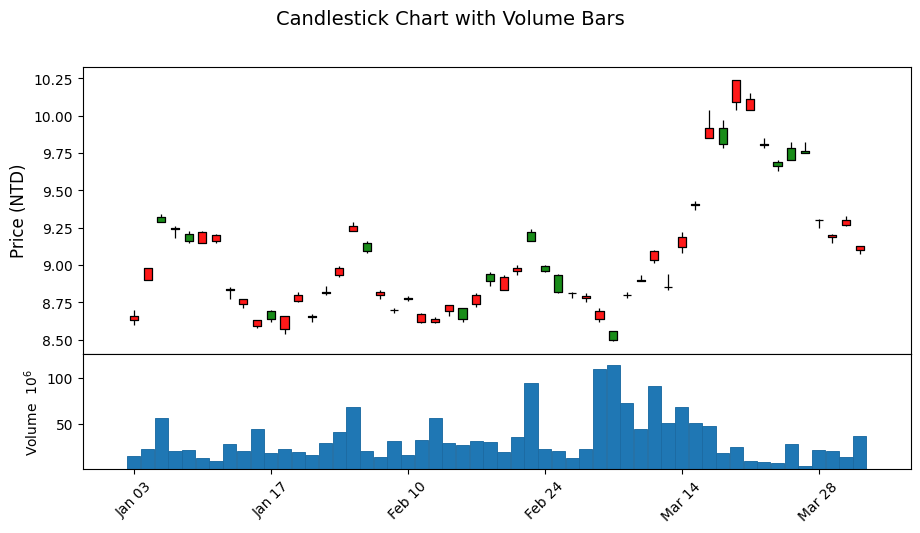

In [10]:
plot_candle(df, '2023-01-01', '2023-04-01')

In [11]:
# Calculate MACD and signal line
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd.macd() # MACD Line
df['macd_histrogram'] = macd.macd_diff() # MACD Histogram
df['macd_signal'] = macd.macd_signal() # Signal Line

# Calculate RSI
rsi = ta.momentum.RSIIndicator(df['Close'], window=5)
df['rsi'] = rsi.rsi()

# Calculate KD
df.ta.stoch(high='high', low='low', k=9, d=3, append=True)
df = df.rename(columns={'STOCHk_9_3_3':'kd_k', 'STOCHd_9_3_3':'kd_d'})

# Calculate DMI
adx = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14)
df['dmi_plus'] = adx.adx_pos()
df['dmi_minus'] = adx.adx_neg()
df['adx'] = adx.adx()

C:\Users\benny\anaconda3\envs\KG\lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\benny\anaconda3\envs\KG\lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [12]:
def plot_indicators(df, start_date, end_date):
    df = df.loc[start_date:end_date].copy().dropna()
    fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    # Plot KD
    if 'kd_k' in df.columns and 'kd_d' in df.columns:
        axs[0].plot(df.index, df['kd_k'], label='K')
        axs[0].plot(df.index, df['kd_d'], label='D')
        axs[0].set_ylabel('KD')
        axs[0].set_xlabel('Date')
        axs[0].legend()
    
    # Plot MACD
    if 'macd' in df.columns and 'macd_signal' in df.columns and 'macd_histrogram' in df.columns:
        axs[1].plot(df.index, df['macd'], label='MACD')
        axs[1].plot(df.index, df['macd_signal'], label='Signal')
        #bar_widths = np.diff(df.index.values).astype(np.int64) / 86400000000000
        axs[1].bar(df.index, 
                   df['macd_histrogram'],
                   width=1, 
                   align='edge', 
                   color=np.where(df['macd_histrogram'] < 0, 'g', 'r'), 
                   label='Histogram')
        axs[1].set_ylabel('MACD')
        axs[1].set_xlabel('Date')
        axs[1].legend()
       
    # Plot RSI
    if 'rsi' in df.columns:
        axs[2].plot(df.index, df['rsi'], label='RSI')
        axs[2].axhline(30, color='green', linestyle='--')
        axs[2].axhline(70, color='green', linestyle='--')
        axs[2].set_ylabel('RSI')
        axs[2].set_xlabel('Date')
        axs[2].legend()
    
    # Plot DMI
    if 'dmi_plus' in df.columns and 'dmi_minus' in df.columns and 'adx' in df.columns:
        axs[3].plot(df.index, df['dmi_plus'], label='+DMI')
        axs[3].plot(df.index, df['dmi_minus'], label='-DMI')
        axs[3].plot(df.index, df['adx'], label='ADX')
        axs[3].axhline(20, color='green', linestyle='--')
        axs[3].set_ylabel('DMI/ADX')
        axs[3].set_xlabel('Date')
        axs[3].legend()
    
    # Get trading dates from DataFrame
    trading_dates = df.index
    
    # Set x-ticks for each subplot
    for ax in axs:
        ax.set_xticks(trading_dates)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))

        # Rotate x-tick labels for better visibility
        if len(df.loc[start_date:end_date]<90):
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    
    plt.show()

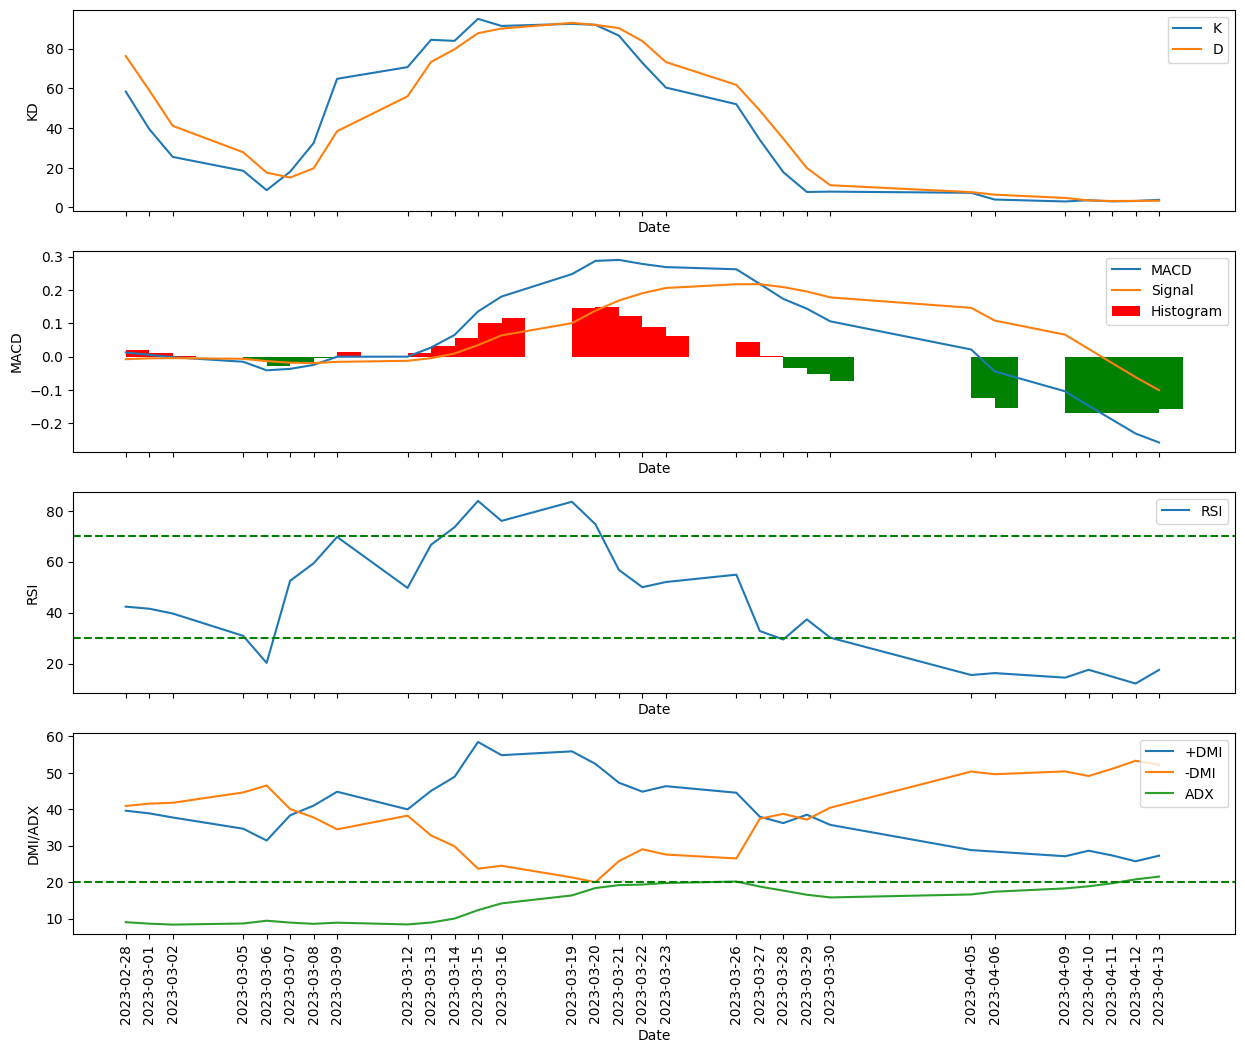

In [13]:
plot_indicators(df, '2023-03-01','2023-04-16') # The blanks of non-trading date are inevitable

## 3. 指定策略

### (1) 合併兩個dataset

In [14]:
dataset = pd.concat([new_df, df], axis=1)
up_down = dataset.pop('up/down')
dataset['Up_Down'] = up_down
dataset['Price(+1)'] = dataset['Close'].shift(-1)
dataset = dataset.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains'], axis=1)
dataset = dataset.dropna()

In [16]:
dataset.tail(20)

,price(0),price(-1),price(-2),price(-3),price(-4),vol(0),vol(-1),vol(-2),vol(-3),vol(-4),...,macd_histrogram,macd_signal,rsi,kd_k,kd_d,dmi_plus,dmi_minus,adx,Up_Down,Price(+1)
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-15 00:00:00+08:00,9.40,9.19,8.85,9.09,8.90,51657100.0,68928177.0,50831000.0,91617000.0,44709111.0,...,0.055654,0.009477,73.547599,83.905105,79.669610,48.873418,29.837860,10.013843,0.21,9.92
2023-03-16 00:00:00+08:00,9.92,9.40,9.19,8.85,9.09,48073098.0,51657100.0,68928177.0,50831000.0,91617000.0,...,0.100806,0.034679,83.862890,94.985662,87.771085,58.443677,23.688814,12.321112,0.52,9.81
2023-03-17 00:00:00+08:00,9.81,9.92,9.40,9.19,8.85,18757106.0,48073098.0,51657100.0,68928177.0,50831000.0,...,0.116486,0.063800,76.023805,91.409288,90.100019,54.831036,24.501873,14.171764,-0.11,10.24
2023-03-20 00:00:00+08:00,10.24,9.81,9.92,9.40,9.19,24989027.0,18757106.0,48073098.0,51657100.0,68928177.0,...,0.147067,0.100567,83.541344,92.473118,92.956023,55.873199,21.293827,16.360286,0.43,10.11
2023-03-21 00:00:00+08:00,10.11,10.24,9.81,9.92,9.40,10143060.0,24989027.0,18757106.0,48073098.0,51657100.0,...,0.149312,0.137895,74.691211,91.980477,91.954295,52.434423,19.983275,18.392485,-0.13,9.80
2023-03-22 00:00:00+08:00,9.80,10.11,10.24,9.81,9.92,8806002.0,10143060.0,24989027.0,18757106.0,48073098.0,...,0.121852,0.168358,56.765977,86.524823,90.326139,47.265357,25.780323,19.179675,-0.31,9.66
2023-03-23 00:00:00+08:00,9.66,9.80,10.11,10.24,9.81,8352000.0,8806002.0,10143060.0,24989027.0,18757106.0,...,0.087783,0.190304,49.992982,72.813239,83.772846,44.814416,29.018920,19.337802,-0.14,9.70
2023-03-24 00:00:00+08:00,9.70,9.66,9.80,10.11,10.24,28967000.0,8352000.0,8806002.0,10143060.0,24989027.0,...,0.062645,0.205965,52.036803,60.369283,73.235782,46.321713,27.569880,19.769209,0.04,9.75
2023-03-27 00:00:00+08:00,9.75,9.70,9.66,9.80,10.11,4524000.0,28967000.0,8352000.0,8806002.0,10143060.0,...,0.044919,0.217195,54.915893,51.997228,61.726584,44.525913,26.501050,20.169800,0.05,9.30


### (2) MACD+KD

### (3) 烏龜戰法

## 4. 進行回測

## 5. 進行統計學習預測股價